In [28]:
%matplotlib inline

import os, sys, json, warnings, time
warnings.filterwarnings("ignore")

from pathlib import Path
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import StratifiedKFold, LearningCurveDisplay, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import category_encoders as ce

import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import AUC

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

f"Tensor version: {tf.__version__}"

'Tensor version: 2.20.0'

Pfade definieren

In [4]:
# ---------- Paths ----------
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd() if Path.cwd().name not in ("notebooks","tools","tests") else Path.cwd().parent

REPORTS_IN  = Path(os.getenv("REPORTS_IN")  or (ROOT / "reports"))         # shared inputs (split, features)
REPORTS_OUT = Path(os.getenv("REPORTS_OUT") or (ROOT / "reports_Charly/NN_target"))  
REPORTS_OUT.mkdir(parents=True, exist_ok=True)

# import loading method
sys.path.insert(0, str(ROOT))
from src.data_loader import load_and_save_data

Speed-Profile erstellen für die Berechnung der Modelle

In [5]:
# ---------- Speed/Profile ----------
SPEED = os.getenv("SPEED", "MEDIUM").upper().strip()
def speed_cfg():
    cfg = dict(CV=5, N_EST=6000, EARLY_STOP=200, MODELS=["lgbm","xgb"], LR=0.03)
    if SPEED == "FAST":
        cfg.update(CV=3, N_EST=2000, EARLY_STOP=50, MODELS=["lgbm"], LR=0.05)
    elif SPEED == "MEDIUM":
        cfg.update(CV=5, N_EST=4000, EARLY_STOP=100)
    elif SPEED == "FULL":
        cfg.update(CV=5, N_EST=8000, EARLY_STOP=300)
    return cfg

CFG        = speed_cfg()
RND        = int(os.getenv("RND", "42"))
CV         = int(os.getenv("CV", str(CFG["CV"])))
N_EST      = int(os.getenv("N_EST", str(CFG["N_EST"])))
ESR        = int(os.getenv("EARLY_STOP", str(CFG["EARLY_STOP"])))
MODELS     = [m.strip() for m in os.getenv("MODELS", ",".join(CFG["MODELS"])).split(",") if m.strip()]
IMB        = os.getenv("IMB", "spw").lower() 
LR         = float(os.getenv("LR", str(CFG["LR"])))
MEMBER     = os.getenv("MEMBER", "Charlotte")

Load the Dataset

In [6]:
# Laden des Datensatzes und alle -1 durch nan ersetzen, da das ML nicht mit nans umgehen kann
data = load_and_save_data().replace(np.nan, -1)

# zur Kontrolle
total_nans = data.isna().sum().sum()
print("total nans: ",total_nans)


Loading dataset from local file: C:\Users\Charlotte Schmid\Nextcloud\Uni\Advanced Data Analytics\Projekt\ada_portoSeguro\data\raw\porto_seguro_safe_driver_prediction.csv
Dataset loaded successfully.
total nans:  0


Strukturierung des Datensatzes von Lucas
Es gibt vier verschiedene Modelle, die wir miteinander vergleichen: 
- drop_calc+opt+extras,37
- drop_calc+extras,39 
- drop_calc_only,37
- all_features,57

Entscheidung: alle ps_calc_* droppen (drop_calc_only),missing_count und sum_all_bin hinzufügen (drop_calc+extras),  zusätzlich ps_ind_14 und ps_car_10_cat droppen (drop_calc+opt+extras) 


In [8]:
# ---------- Utils ----------
# Variablen nach Skalenniveau sortieren
def split_cols(cols):
    cat = [c for c in cols if str(c).endswith("_cat")]
    bin = [c for c in cols if str(c).endswith("_bin")]
    num  = [c for c in cols if c not in cat and c not in bin and c != "target"]
    return cat, bin, num

# Extra-variablen erstellen
def fe_extras(X, selected):
    X = X.copy()
    if "missing_count" in selected:
        X["missing_count"] = X.isna().sum(axis=1)
    if "sum_all_bin" in selected:
        b = [c for c in X.columns if str(c).endswith("_bin")]
        X["sum_all_bin"] = X[b].sum(axis=1) if b else 0
    return X

# Datensatz mit ausgewählten Spalten erstellen
def load_selected_feature_list():
    f = REPORTS_IN / "features_selected.csv"
    if not f.exists():
        raise FileNotFoundError(f"Missing {f}. Run feature-gate first.")
    s = pd.read_csv(f)
    if "raw_feature" not in s.columns:
        raise ValueError("features_selected.csv must have column 'raw_feature'.")
    return s["raw_feature"].astype(str).tolist()

var_selected = load_selected_feature_list() # 35 Feature anstatt 57

# Originalspalten für das Model auswählen nach PCA
X_temp = data[var_selected[:-2]]  # alles von Anfang bis zweitletzte Spalte
var_cat, var_bin, var_num = split_cols(X_temp.columns)

# Extra-Features erstellen
X = fe_extras(data, var_selected)

# kompletten Datensatz für drop_calc+opt+extras erstellen
X = X[var_selected]
y = data["target"]

# zusätzliche Features der Kategorie var_num hinzufügen 
var_num.append("missing_count")
var_num.append("sum_all_bin")


X.shape, y.shape

((595212, 37), (595212,))

In [9]:
# zur Kontrolle
print(var_cat) # 13 Variablen
print(var_num) # 13 Variablen
print(var_bin) # 11 Variablen

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat']
['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'missing_count', 'sum_all_bin']
['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


Train-Test Split

In [11]:
## Split von split_indices übernommen: 
split_p = REPORTS_IN / "split_indices.json"
split = json.loads(split_p.read_text())

# Datensatz aufsplitten nach der json-Datei
X_train = X.loc[split["train"]]
y_train = y.loc[split["train"]]
X_test = X.loc[split["test"]]
y_test = y.loc[split["test"]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((200000, 37), (200000,), (50000, 37), (50000,))

### Pre-Processing

Aus der EDA kennen wir die einzelne Variablen. 
- es müssen fehlende Werte ersetzt werden
- Kategoriale Variablen mit weniger als 10 Variablen onehotencoden mit fehlenden Werten als eigene Kategorie und größere Varialben mit Target Encoder verwerten
- Standardisierung der numerischen Variablen

Alle Variablen mit 3 Levels sind eigentlich auch binär, nur die fehlenden Werte müssen imputiert werden 
Alle Variablen mit mehr als 3 Leves sind ordinal kodiert und werden nicht onehotencoded.

In [12]:
# Sortieren der kategorialen  Variablen nach vielen und wenigen Kategorien
small_cat = [col for col in var_cat if X[col].nunique() < 10]
large_cat = [col for col in var_cat if X[col].nunique() >= 10]
small_cat,large_cat

(['ps_ind_02_cat',
  'ps_ind_04_cat',
  'ps_ind_05_cat',
  'ps_car_02_cat',
  'ps_car_03_cat',
  'ps_car_05_cat',
  'ps_car_07_cat',
  'ps_car_08_cat',
  'ps_car_09_cat'],
 ['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat'])

In [10]:
for var in large_cat: 
    print(var, X[var].unique())

ps_car_01_cat [10. 11.  7.  6.  9.  5.  4.  8.  3.  0.  2.  1. -1.]
ps_car_04_cat [0 1 8 9 2 6 3 7 4 5]
ps_car_06_cat [ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]
ps_car_11_cat [ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


In [16]:
# Pipeline für numerische Features
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline für kleine kategoriale Features
cat_small_pipeline = Pipeline([
    # kein Imputer, da -1 jetzt als eigene Kategorie mit einbezogen wird
    ("onehot", OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore"))
])

# Pipeline für große kategoriale Features
target_encoder = ce.TargetEncoder(cols=["ps_car_11_cat"], smoothing=0.3) # Kategorie mit höchster Kardinalität
cat_large_pipeline = Pipeline([
    # kein Imputer, da -1 jetzt als eigene Kategorie mit einbezogen wird
    ("encoder", target_encoder)
])

# Pipeline für binäre Features
bin_pipeline = Pipeline([
    # bei binären Variablen wird die häufigste Kategorie gewählt, damit sie binär bleiben und keine 3. Kategorie dazu kommt
    ("impute", SimpleImputer(strategy="most_frequent", missing_values=-1))
])

ps_preprocessor = ColumnTransformer([
    ("var_num", num_pipeline, var_num),
    ("small_cat", cat_small_pipeline, small_cat),
    ("large_cat", cat_large_pipeline, large_cat),
    ("var_bin", bin_pipeline, var_bin)
])

ps_preprocessor

,transformers,"[('var_num', ...), ('small_cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [17]:
# Transformieren der Daten
X_processed_train = ps_preprocessor.fit_transform(X_train, y_train)
X_processed_test = ps_preprocessor.transform(X_test)


print(X_processed_train.shape, X_processed_test.shape)


(200000, 55) (50000, 55)


Model Setup

In [18]:
# Model als Funktion definieren, um Kreuzvalidierung durchführen zu können
def create_model(dropout_rate=0.2, learning_rate=0.001, input_dim=None):
    inputs = Input(shape=(input_dim,), name="data_input")
    
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1,activation='sigmoid')(x)

    # Optimizer mit eigener Lernrate definieren
    optimizer = Adam(learning_rate = learning_rate)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name="auc")]) 
    return model

Model Training

In [ ]:
# Modeldefinieren
model_base = create_model(input_dim = X_processed_train.shape[1])

# Parameter definieren
epochs = 10
early_stop = EarlyStopping(monitor='val_auc', mode = "max", patience=3, restore_best_weights=True)

# Zeit messen
start = time.perf_counter()

# Modell trainieren
history_base = model_base.fit(
    X_processed_train, y_train,
    validation_data=(X_processed_test, y_test),
    epochs=epochs, 
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9632 - auc: 0.5688 - loss: 0.1618 - val_accuracy: 0.9634 - val_auc: 0.6306 - val_loss: 0.1528
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9634 - auc: 0.5903 - loss: 0.1569 - val_accuracy: 0.9634 - val_auc: 0.6321 - val_loss: 0.1527
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9634 - auc: 0.6021 - loss: 0.1554 - val_accuracy: 0.9634 - val_auc: 0.6338 - val_loss: 0.1535
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9634 - auc: 0.6032 - loss: 0.1550 - val_accuracy: 0.9634 - val_auc: 0.6329 - val_loss: 0.1542
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9635 - auc: 0.6089 - loss: 0.1544 - val_accuracy: 0.9634 - val_auc: 0.6364 - val_loss: 0.1534
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9634 - auc: 0.6127 - loss: 0.1542 - val_accuracy: 0.9634 - val_auc: 0.6395 - val_loss: 0.1525
Epoch 7/10
6250/6250 ━

Grafiken für Trainingsverlauf
- Trainings- und Validierungs-Loss
- Accuracy

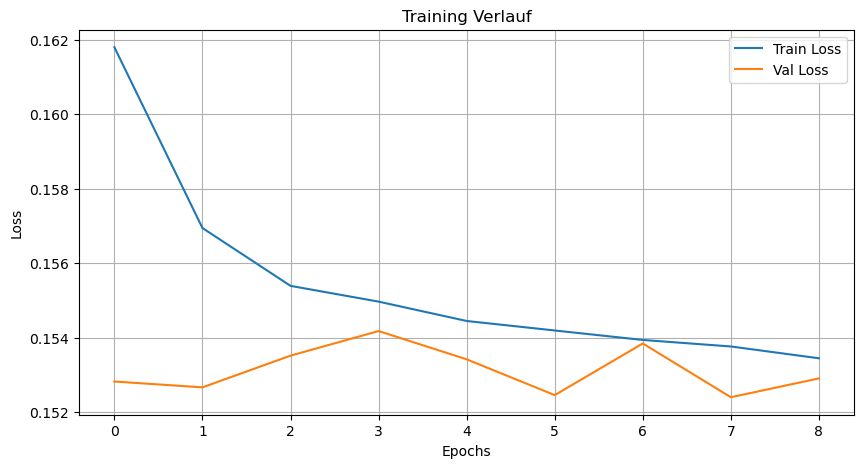

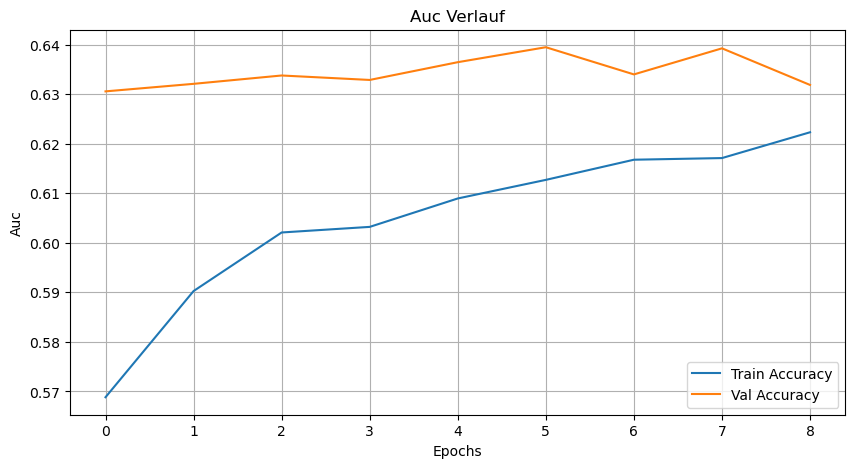

In [16]:
# Trainings- und Validierungs-Loss
plt.figure(figsize=(10,5))
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_train_loss.png", dpi=150); plt.close()

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history_base.history['auc'], label='Train Accuracy')
plt.plot(history_base.history['val_auc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Auc')
plt.title('Auc Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_accuracy.png", dpi=150); plt.close()


Model Tuning
1. Schritt: Lernkurve erstellen, um das Sample für das Model Tuning zu verkleinern
2. Schritt: Validierungskurven für Hyperparameter berechnen, um zu optimieren

Lernkurve berechnen

In [23]:
# Wrapper für scikit-learn erstellen
clf = KerasClassifier(
    build_fn=create_model,
    dropout_rate = 0.2,
    learning_rate = 0.001,
    input_dim=X_processed_train.shape[1],
    epochs=50,
    batch_size=32,
    verbose=0
)

# Kreuzvalidierung definieren 
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RND)

[learning_curve] Training set sizes: [  8000  24000  40000  56000  72000  88000 104000 120000 136000 152000]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 65.0min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 66.8min finished


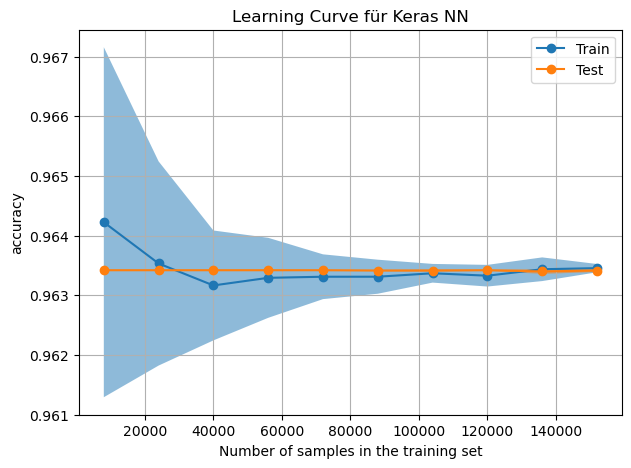

In [ ]:
# Trainingsgrößen definieren
train_sizes = np.arange(0.05, 1.05, 0.1 )

# Grafik erstellen 
fig, ax = plt.subplots(figsize=(7,5))

LearningCurveDisplay.from_estimator(
    estimator=clf,
    X=np.array(X_processed_train),  # flaches Array
    y=np.array(y_train),
    train_sizes=train_sizes,
    cv=skf,
    shuffle=True,
    score_type="both",  # Trainings- und Validierungsscore
    line_kw={"marker":"o"},
    score_name="accuracy",
    ax=ax,
    verbose=1
)

ax.set_title("Learning Curve für Keras NN")
ax.grid(True)
plt.savefig(REPORTS_OUT/"plot_learningcurve.png", dpi=150); plt.close()
plt.show()

Interpretation: 
Die Lernkurve zeigt, dass nach 55% der Daten keine wirkliche Verbesserung der Genauigkeit mehr erreich wird. Es wurde mit Validierung Und Trainingsdatensatz gerechnet. Das heißt bei 88.000 Trainingsdaten sind 22.000 Validierungsdaten dabei. Dieses Sample wird verwendet um die Validierung der Hyperparameter durchzuführen 

In [19]:
# Sample von mit 55% der Daten erstellen
sample_fraction = 0.55 
n_samples = int(len(X_processed_train) * sample_fraction)

# Zufällige Indizes auswählen
np.random.seed(RND) 
sample_idx = np.random.choice(len(X_processed_train), size=n_samples, replace=False)

# Sample erstellen
X_sample = X_processed_train[sample_idx] 
y_sample = y_train.values[sample_idx]

X_sample.shape, y_sample.shape

((110000, 55), (110000,))

Kreuzvalidierung

In [39]:
# Parameterbereiche für Dropout und Lernrate festlegen
dropout_range = np.linspace(0.0, 0.5, 6)    # Dropout von 0.0 bis 0.5
learning_range = [0.0001, 0.001, 0.01, 0.1]
batch_range = [32, 64]
#neuron_range = [32, 64]

early_stop = EarlyStopping(monitor='val_auc', mode = "max", patience=3, restore_best_weights=True)


In [34]:
# Kreuzvalidierung per Hand
results = []

for rate in dropout_range:
    clf = KerasClassifier(
        build_fn=create_model,
        dropout_rate=rate,              
        learning_rate=0.001,
        input_dim=X_processed_train.shape[1],
        epochs=50,
        batch_size=32,
        verbose=0, 
        fit__callbacks=[early_stop],
        fit__validation_split=0.2   # damit EarlyStopping val_auc überwachen kann
    )

    # Kreuzvalidierung
    scores = cross_val_score(
        clf,
        X_sample,
        y_sample,
        cv=skf,
        scoring="average_precision",
    )
    
    results.append(scores.mean())
    print(f"Dropout {rate:.2f}: AUC = {scores.mean():.4f} (+/- {scores.std():.4f})")

# Ergebnisse in Plot
plt.figure(figsize=(6,4))
plt.plot(dropout_range, results, marker="o")
plt.title("Cross-Validation Performance vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Average Precision (CV mean)")
plt.grid(True)

plt.savefig(REPORTS_OUT/"plot_dropoutrate_val.png", dpi=150)
plt.show()

Epoch 1/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9619 - auc: 0.5770 - loss: 0.1590 - val_accuracy: 0.9632 - val_auc: 0.6001 - val_loss: 0.1554
Epoch 2/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9638 - auc: 0.6125 - loss: 0.1533 - val_accuracy: 0.9632 - val_auc: 0.6063 - val_loss: 0.1552
Epoch 3/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9638 - auc: 0.6205 - loss: 0.1524 - val_accuracy: 0.9632 - val_auc: 0.6070 - val_loss: 0.1555
Epoch 4/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9638 - auc: 0.6241 - loss: 0.1520 - val_accuracy: 0.9632 - val_auc: 0.6011 - val_loss: 0.1559
Epoch 5/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9638 - auc: 0.6345 - loss: 0.1511 - val_accuracy: 0.9632 - val_auc: 0.6052 - val_loss: 0.1564
Epoch 6/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9638 - auc: 0.6398 - loss: 0.1507 - val_accuracy: 0.9632 - val_auc: 0.6049 - val_loss: 0.1556
Epoch 1/50
2200/2200 ━━━━━━━

KeyboardInterrupt: 

KeyboardInterrupt: 

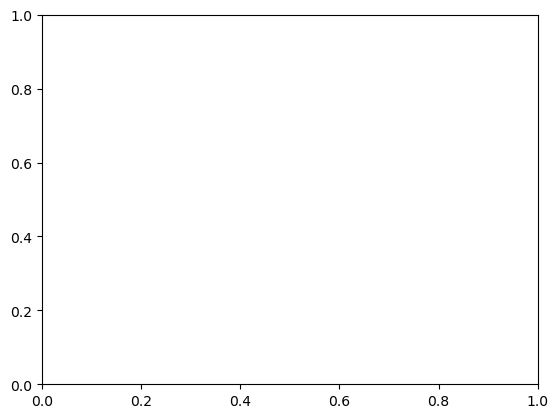

In [26]:
# Plot vorbereiten
fig, ax = plt.subplots()

# Validierungskurve für Lernrate bestimmen
ValidationCurveDisplay.from_estimator(
    clf,
    X_sample,
    y_sample,
    param_name="learning_rate",
    param_range=learning_range,
    cv=skf,
    scoring="average_precision",
    score_type="both",
    line_kw={"marker": "o"},
    fit_params={"callbacks": [early_stop]},
    ax=ax,
)
ax.set_title("Validation Curve: Learning Rate")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Average Precision")
ax.set_xscale("log")

ax.grid(True)


plt.tight_layout()
plt.savefig(REPORTS_OUT/"plot_learningrate_val.png", dpi=150); plt.close()
plt.show()


Batch_Size = 32.00: AUC = nan (+/- nan)
Batch_Size = 64.00: AUC = nan (+/- nan)


ValueError: x and y must have same first dimension, but have shapes (6,) and (2,)

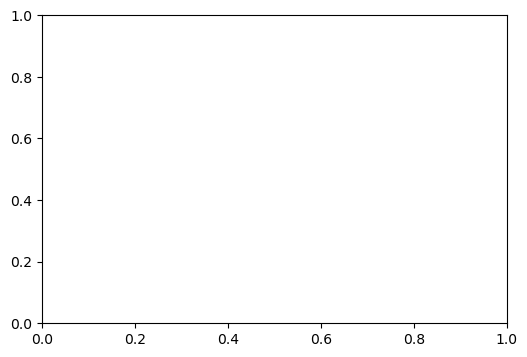

In [ ]:
# Kreuzvalidierung der BatchSize
results = []

for batch in batch_range:
    clf = KerasClassifier(
        build_fn=create_model,
        dropout_rate=0.2,              
        learning_rate=0.001,
        input_dim=X_processed_train.shape[1],
        epochs=50,
        batch_size=batch,
        verbose=0, 
        fit__callbacks=[early_stop],
        fit__validation_split=0.2   # damit EarlyStopping val_auc überwachen kann
    )

    # Kreuzvalidierung
    scores = cross_val_score(
        clf,
        X_sample,
        y_sample,
        cv=skf,
        scoring="average_precision",
    )
    
    results.append(scores.mean())
    print(f"Batch_Size = {batch:.2f}: AUC = {scores.mean():.4f} (+/- {scores.std():.4f})")

# Ergebnisse in Plot
plt.figure(figsize=(6,4))
plt.plot(batch_range, results, marker="o")
plt.title("Cross-Validation Performance vs Dropout Rate")
plt.xlabel("Batch Size")
plt.ylabel("Average Precision (CV mean)")
plt.grid(True)

plt.savefig(REPORTS_OUT/"plot_BatchSize_val.png", dpi=150)
plt.show()

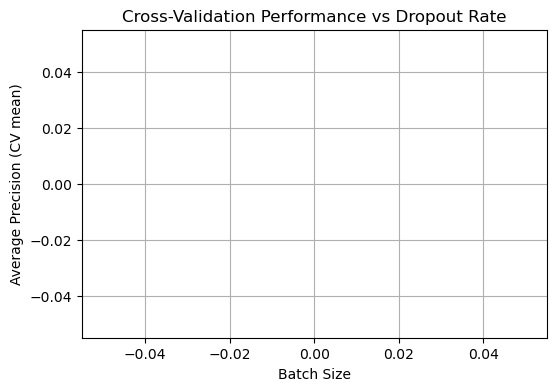

In [44]:
# Ergebnisse in Plot
plt.figure(figsize=(6,4))
plt.plot(batch_range, results, marker="o")
plt.title("Cross-Validation Performance vs Dropout Rate")
plt.xlabel("Batch Size")
plt.ylabel("Average Precision (CV mean)")
plt.grid(True)

plt.savefig(REPORTS_OUT/"plot_BatchSize_val.png", dpi=150)
plt.show()

In [27]:
# Plot vorbereiten
fig, ax = plt.subplots()

# Validierungsplot für Batch-Size
ValidationCurveDisplay.from_estimator(
    clf,
    X_sample,
    y_sample,
    param_name="batch_size",
    param_range= batch_range,
    cv=skf,
    scoring="roc_auc",
    score_type="both",
    line_kw={"marker": "o"},
    fit_params={"callbacks": [early_stop]},
    ax=ax,
)
ax.set_title("Validation Curve: Bach Size")
ax.set_xlabel("Batch Size")
ax.set_ylabel("roc_auc")
ax.grid(True)


plt.tight_layout()
plt.savefig(REPORTS_OUT/"plot_bachsize_val.png", dpi=150); plt.close()
plt.show()

Finales Model fitten

In [51]:
model_final = create_model(input_dim = X_processed_train.shape[1], dropout_rate = 0.2, learning_rate = 0.001,)

# Parameter definieren
epochs = 20
early_stop = EarlyStopping(monitor='val_auc', mode = "max", patience=3, restore_best_weights=True)

# Zeit messen
start = time.perf_counter()

# Modell trainieren
history_final = model_final.fit(
    X_processed_train, y_train,
    validation_data=(X_processed_test, y_test),
    epochs=epochs, 
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9631 - auc: 0.5663 - loss: 0.1623 - val_accuracy: 0.9634 - val_auc: 0.6191 - val_loss: 0.1537
Epoch 2/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9634 - auc: 0.5905 - loss: 0.1569 - val_accuracy: 0.9634 - val_auc: 0.6278 - val_loss: 0.1537
Epoch 3/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9634 - auc: 0.5969 - loss: 0.1557 - val_accuracy: 0.9634 - val_auc: 0.6215 - val_loss: 0.1536
Epoch 4/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9634 - auc: 0.6095 - loss: 0.1547 - val_accuracy: 0.9634 - val_auc: 0.6372 - val_loss: 0.1525
Epoch 5/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9634 - auc: 0.6096 - loss: 0.1545 - val_accuracy: 0.9634 - val_auc: 0.6332 - val_loss: 0.1529
Epoch 6/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9634 - auc: 0.6120 - loss: 0.1542 - val_accuracy: 0.9634 - val_auc: 0.6311 - val_loss: 0.1532
Epoch 7/20
6250/6250 ━━━━━━━

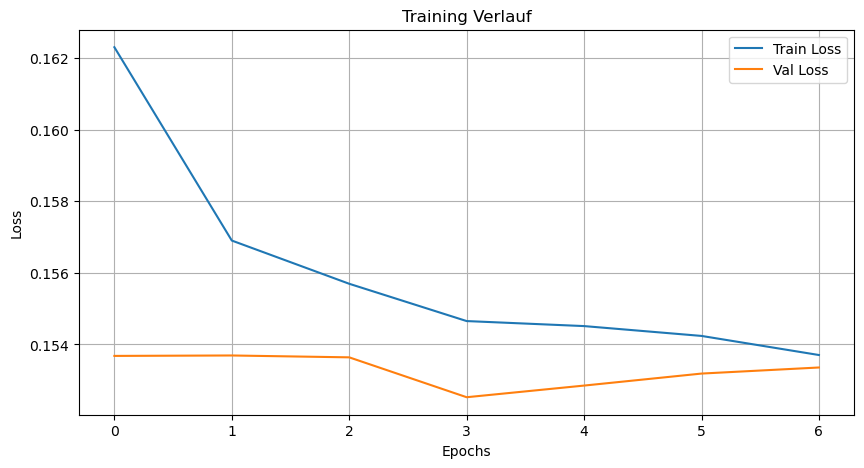

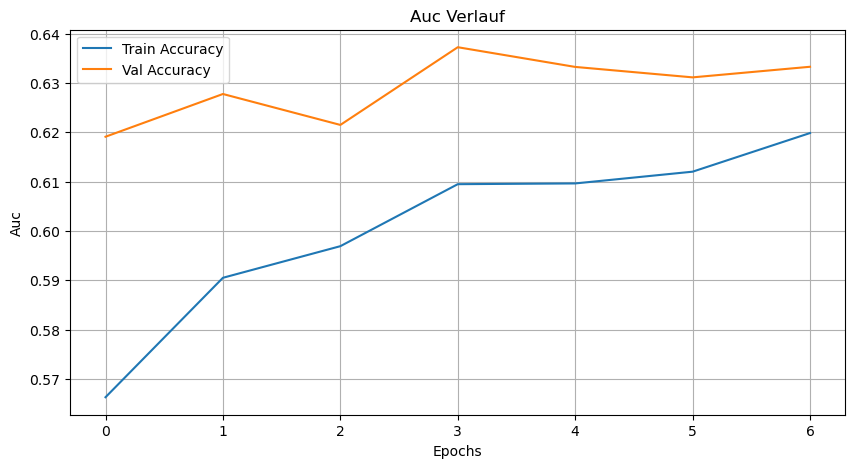

In [53]:
# Grafiken für Trainingsverlauf
# Trainings- und Validierungs-Loss
plt.figure(figsize=(10,5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_final_train_loss.png", dpi=150); plt.close()

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history_final.history['auc'], label='Train Accuracy')
plt.plot(history_final.history['val_auc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Auc')
plt.title('Auc Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_final_accuracy.png", dpi=150); plt.close()


Vergleichsmetriken berechnen
- Crossvalidation
- Holdout
- Time

Durchführung der Kreuzvalidierung

In [47]:
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RND)

auc_scores = []
ap_scores = []

for train_idx, val_idx in skf.split(X_processed_train, y_train):
    # der Trainingsdatensatz wird in Trainings- und Validierungsteildatensatz gesplittet:
    X_processed_tr, X_processed_val = X_processed_train[train_idx], X_processed_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Neues Model pro Fold erstellen
    model_cv = create_model(input_dim = X_processed_train.shape[1], dropout_rate=0.2,learning_rate=0.001)

    # Trainieren der Modelle
    model_cv.fit(
        X_processed_tr, y_tr,
        validation_data = (X_processed_val, y_val),
        epochs = 50, 
        batch_size = 32, 
        callbacks = [early_stop],
        verbose = 0
    )

    # Vorhersagen (Wahrscheinlichkeiten)
    y_val_pred = model_cv.predict(X_processed_val, verbose=0).ravel()

    # Metriken
    auc_scores.append(roc_auc_score(y_val, y_val_pred))
    ap_scores.append(average_precision_score(y_val, y_val_pred))

# Ergebnisse
cv_auc_mean = np.mean(auc_scores)
cv_ap_mean = np.mean(ap_scores)

#best_model = max(baselines.items(), key=lambda kv: kv[1]["pr_auc"])[0]

print("CV AUC mean:", cv_auc_mean)
print("CV AP mean:", cv_ap_mean)

CV AUC mean: 0.6167493292602247
CV AP mean: 0.06050871858890452


Genauigkeit mit dem Testdatensatz überprüfen

In [49]:
# Holdout mit bisher nicht genutzten Testdaten

model_holdout = create_model(input_dim = X_processed_train.shape[1], dropout_rate=0.2, learning_rate=0.001)

model_holdout.fit(
    X_processed_train,
    y_train,
    validation_split=0.1,   # kleiner Teil für val_loss Monitoring
    epochs=50,
    batch_size = 32, 
    callbacks=[early_stop],
    verbose=1
)

# Vorhersagen auf Holdout_Testset
y_pred_proba = model_holdout.predict(X_processed_test, verbose=0).ravel()

# Metriken berechnen
hold_auc = roc_auc_score(y_test, y_pred_proba)
hold_ap = average_precision_score(y_test, y_pred_proba)
hold_brier = brier_score_loss(y_test, y_pred_proba)

print("Holdout AUC:", hold_auc)
print("Holdout AP:", hold_ap)
print("Holdout Brier Score:", hold_brier)

Epoch 1/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9626 - auc: 0.5616 - loss: 0.1641 - val_accuracy: 0.9610 - val_auc: 0.6113 - val_loss: 0.1619
Epoch 2/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9637 - auc: 0.5899 - loss: 0.1563 - val_accuracy: 0.9610 - val_auc: 0.6115 - val_loss: 0.1613
Epoch 3/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9637 - auc: 0.5981 - loss: 0.1549 - val_accuracy: 0.9610 - val_auc: 0.6169 - val_loss: 0.1628
Holdout AUC: 0.6360372088413522
Holdout AP: 0.06739429271512327
Holdout Brier Score: 0.03494049014823667


Zeitmessung

In [56]:
# Zeitmetriken berechnen
fit_time_s = time.perf_counter() - start

# Vorhersagezeit auf 1000 Samples selbst berechnen, da keine eigene Metrik vorhanden
n_samples = 1000
X_sample = X_processed_test[:n_samples] # fixes Sample von 1000

start_1000 = time.perf_counter()
y_pred_sample = model_final.predict(X_sample, verbose=0)
elapsed= (time.perf_counter() - start_1000) * 1000  # in ms
predict_time_ms_per_1k = elapsed

print("Fit time (s):", fit_time_s)
print("Predict time (ms/1k):", predict_time_ms_per_1k)

Fit time (s): 337.6159170998726
Predict time (ms/1k): 135.44029998593032


In [57]:
# beste Epoche (Epoche mit bestem Wert äquivalent zu best_iteration)
best_iteration = early_stop.stopped_epoch - early_stop.patience

print("Best iteration:", best_iteration)

Best iteration: 3


Zusammenfassung der Berichte

In [62]:
# save predictions
pd.DataFrame({"proba": y_pred_proba, "y_true": y_test.values}).to_csv(REPORTS_OUT/"holdout_preds.csv", index=False)

# save metrics
row = {
    "member": MEMBER,
    "model_name": "NN_target", #best_model.upper(),
    "encoder": "OneHotEncoder and Target Encoding for large categories",
    "split_path": "split_indices.json",
    "feature_recipe": "selected_from_feature_gate",
    "seed": RND, "cv_folds": CV,
    "hold_auc": hold_auc, "hold_ap": hold_ap, "hold_brier": hold_brier,
    "cv_auc_mean": cv_auc_mean, "cv_ap_mean": cv_ap_mean,
    "early_stopping": True,
    "best_iteration": best_iteration,
    "n_trees": (epochs, "Epochs"),
    "fit_time_s": fit_time_s,
    "predict_time_ms_per_1k": predict_time_ms_per_1k,
    "params_json": None, #json.dumps(best_params),
}

out_csv = REPORTS_IN/"team_model_summary.csv"
pd.DataFrame([row]).to_csv(out_csv, mode="a", index=False, header=not out_csv.exists())

Grafiken erstellen
- ohne Feature Importance

In [63]:
def save_pr_curve(y_test, proba, out_path):
    import matplotlib.pyplot as plt
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.figure(figsize=(7,5))
    plt.plot(rec, prec, label=f'AP={ap:.4f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')
    plt.xlim([0,1]); plt.ylim([0,1]); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()

def save_calibration(y_test, proba, out_path):
    import matplotlib.pyplot as plt
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=20, strategy="quantile")
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--',label='Perfect')
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.xlabel('Predicted'); plt.ylabel('Observed'); plt.title('Calibration')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()

save_pr_curve(y_test.values, y_pred_proba, REPORTS_OUT/"plot_pr.png")
save_calibration(y_test.values, y_pred_proba, REPORTS_OUT/"plot_calibration.png")